# Computing for Life Sciences 2023
## Machine Learning Workshop - Exploring small molecule potency

## Outline
- Task Overview
- Data Exploring
- Supervised Learning
    - ~~Classification (Less-potent vs Potent PPI inhibitors)~~ (Lecture 1 - Alex de Sá)
    - Regression (PPI inhibitory potency)
        - Decision Tree
        - Performance Evaluation
        - Random Forest - Ensemble methods

### Task Overview
The problem we will solve is **predicting inhibitory activity of small molecules against certain protein-protein interactions (PPIs)**. 

Proteins rarely act alone as their functions tend to be regulated. Many molecular processes within a cell are dependents of PPIs. Some PPIs are involved in multiple aggregation-related diseases, such as Creutzfeldt–Jakob and Alzheimer's diseases. The discovery of novel molecules capable of inhibiting these processes can be of great importance for medicine.

Small molecules are low molecular weight molecules that include lipids, monosaccharides, second messengers, other natural products and metabolites, as well as drugs and other xenobiotics. They can interact with receptors and regulate biological processes. 

The first thing we need is a data set with inhibitory activity values for real molecules. For this workshop, we will use datasets from [TIMBAL](https://pubmed.ncbi.nlm.nih.gov/23766369/) and [iPPIDB](https://pubmed.ncbi.nlm.nih.gov/33416858/). 

The inhibitory activity values are reported in **-log(IC50)**. IC50 means how much of a particular inhibitory drug is needed to inhibit a given biological process or biological component by 50\%. It is measured in uM (micromolar).


### Loading general libraries

In [123]:
# AUTO-RELOAD EXTENSIONS
%load_ext autoreload
%autoreload 2

# PLOTTING
from plotly.offline import iplot, init_notebook_mode
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
# Set notebook mode to work in offline
pyo.init_notebook_mode()

# DATA MANIPULATION
import numpy as np
import pandas as pd

# PREVENTS GENERAL WARNINGS FROM SHOWING ON OUTPUT
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Exploration

In [124]:
!wget https://raw.githubusercontent.com/carlosmr12/mlwk2023/master/data/ppi_inhibitors.csv

--2023-07-03 20:04:41--  https://raw.githubusercontent.com/carlosmr12/mlwk2023/master/data/ppi_inhibitors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240318 (235K) [text/plain]
Saving to: ‘ppi_inhibitors.csv.1’

ppi_inhibitors.csv. 100%[===================>] 234.69K  --.-KB/s    in 0.1s    

2023-07-03 20:04:41 (1.91 MB/s) - ‘ppi_inhibitors.csv.1’ saved [240318/240318]



In [125]:
df_data = pd.read_csv("ppi_inhibitors.csv") # Load data from file to a DataFrame structure
print(df_data.shape) # .shape displays how the dataframe (matrix) looks like
df_data.head() # .head() displays the first few items in the dataframe

(2259, 9)


SMILES database  MolLogP  \
0  CN(C)CC[C@H](CSc1ccccc1)Nc1ccc(cc1S(=O)(=O)C(F...   ippidb  8.43850   
1  CSCC[C@H]1NC(=O)CSC[C@H](NC(=O)[C@H](CC(=O)O)N...   timbal -3.84540   
2  CC1CC(C)CN(C1)C2CC(N(C2)S(=O)(=O)c3cccc(c3)C#N...   timbal  4.43398   
3  Cc1cc(Cl)cc([C@@H](CC(=O)O)NC(=O)CNC(=O)c2cc(O...   timbal  0.85362   
4  NC(=N)NCCC[C@@H]1NC(=O)[C@H](Cc2c[nH]cn2)NC(=O...   timbal -4.42303   

   Acceptor_Count  Donor_Count  NumRotatableBonds  RingCount    MolWt  \
0               6            5                 16          7  928.569   
1               9            9                 10          1  620.711   
2               7            4                 10          5  727.671   
3               7            8                  8          3  519.942   
4              10           12                  9          2  626.653   

   Experimental IC50 (log10)  
0                   7.310000  
1                   7.552842  
2                   9.853872  
3                   6.162412  
4                   8.522879

Data distribution based on data sources

In [126]:
print(df_data['database'].value_counts())

fig = px.pie(df_data, values=df_data['database'].value_counts().values, 
             names=df_data['database'].value_counts().index, 
             title='Data sources')

fig.show(renderer="colab")

database
timbal    1315
ippidb     944
Name: count, dtype: int64


The molecules of the dataset are represented through **SMILES**. SMILES is a chemical notation that allows representation of a chemical structure.  They can be represented using simple vocabulary (atom and bond symbols), and few grammar rules: 

- ***2-Propanol would be “CC(O)C”***

- ***2-Methylbutanal would be “CC(C)CC(=O)”.***

Using a type of SMILES called ISOMERIC SMILES it is even possible to represent specific isotopism, configuration about double bonds, and chirality. 

Below you can see some examples of SMILES in our data:


2D depiction of small molecules based on the SMILES format

In [127]:
# IMPORTING LIBRARIES FROM RDKIT
from rdkit.Chem.Draw import IPythonConsole #RDKit drawing
# A few settings to improve the quality of structures 
from rdkit.Chem import rdDepictor
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)

from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit import Chem

CN(C)CC[C@H](CSc1ccccc1)Nc1ccc(cc1S(=O)(=O)C(F)(F)F)S(=O)(=O)Nc1ncnc2CN(CCc12)C1CCN(Cc2ccccc2-c2cccc(Cl)c2)CC1


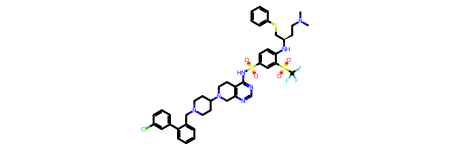

In [128]:
print(df_data.iloc[0]['SMILES'])
m = Chem.MolFromSmiles(df_data.iloc[0]['SMILES'])
m

CC(C)C(=O)c1cc(C(=O)c2ccc(Oc3ccccc3)cc2)c(O)c(O)c1O


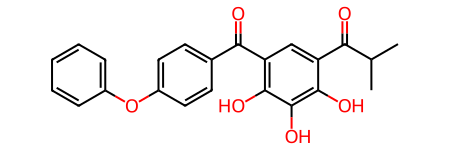

In [129]:
print(df_data.iloc[-1]['SMILES'])
m = Chem.MolFromSmiles(df_data.iloc[-1]['SMILES'])
m

CSCC[C@H]1NC(=O)CSC[C@H](NC(=O)[C@H](CC(=O)O)NC(=O)CNC(=O)[C@H](CCCN=C(N)N)NC1=O)C(=O)O


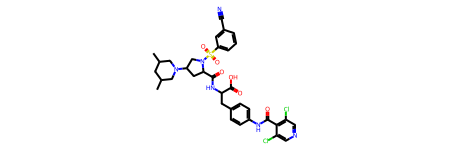

In [130]:
print(df_data.iloc[1]['SMILES'])
m = Chem.MolFromSmiles(df_data.iloc[2]['SMILES'])
m

What does the distribution of our **target** variable look like?

In [131]:
target = "Experimental IC50 (log10)"
fig = px.histogram(df_data, x=target)
fig.show(renderer="colab")

Why do we would preferably work with the target variable in a log scale?

In [132]:
df_data['inverse_log'] = 10**df_data[target]
fig = px.histogram(df_data, x='inverse_log')
fig.show(renderer="colab")

It is also important to note that ours datasets covers, besides a long range of concentrations, also a range of values for diferent properties. This is also important to generate more generalised  models.

An important concept here is **feature**. A feature is a property of the object you’re trying to predict. It can also be referred to as indepent variable, since it is a fixed property of the data point and it does not depend of others variables. These independent variables are essential, because the algorithms need characteristics of the data points as support for the learning process and predicting the labels (in our case inhibitory activity).

In [133]:
columns = ["MolLogP", "Acceptor_Count", "Donor_Count", "NumRotatableBonds",
           "RingCount", "MolWt"]

fig = make_subplots(rows=3, cols=2, start_cell="bottom-left")

nlines = 3
ncolumns = 2

for i in range(nlines):
    for j in range(ncolumns):
        fig.add_trace(go.Histogram(x=df_data[columns[i+j]], name=columns[i+j]), row=i+1, col=j+1)

fig.update_yaxes(title="count")
fig.show(renderer="colab")

### Regression (PPI inhibitory potency)

#### Data Preparation

The method **train_test_split()** used in the code below divides our data into two subsets: 

- One subset to *train* the model
- A subset to evaluate or *test* how good your model is, which should
    - Be large enough to yield statistically meaningful results
    - Be representative of the data set as whole

*(Never train on test data)*

Splitting your dataset into training and test sets is very important and it is directly related to your models ability to *learn* patterns during the training step, which will ideally help to make it generalisable. Using the test set (a subset completely unseen during trainning) you can estimate the performance of the model when it is applied to new data points.

In [134]:
from sklearn.model_selection import cross_val_predict, train_test_split

# What is the best TEST_SIZE?
TEST_SIZE = 0.2

columns = ["MolLogP", "Acceptor_Count", "Donor_Count", "NumRotatableBonds",
           "RingCount", "MolWt"]
X = df_data[columns]
target = "Experimental IC50 (log10)"
y = df_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

fig = make_subplots(rows=1, cols=2, start_cell="bottom-left")

fig.add_trace(go.Histogram(x=y_train, name='Training set'), row=1, col=1)
fig.add_trace(go.Histogram(x=y_test, name='Test set'), row=1, col=2)
fig.update_xaxes(title=target)
fig.update_yaxes(title="count")
fig.show(renderer="colab")

#### Decision Tree

In [135]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=3)
print(regressor.get_params())

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [136]:
y_pred_train = cross_val_predict(regressor, X_train, y_train, cv=5)
regressor.fit(X_train, y_train)

y_pred_test = regressor.predict(X_test)

In [137]:
from scipy.stats import pearsonr, kendalltau, spearmanr
from sklearn.metrics import mean_squared_error
from math import sqrt
from tabulate import tabulate

def regression_metrics(y_train, y_pred_train, y_test, y_pred_test):
    rmse_train = round(sqrt(mean_squared_error(y_train, y_pred_train)), 2)
    pearsons_train = round(pearsonr(y_train, y_pred_train)[0], 2)
    kendalls_train = round(kendalltau(y_train, y_pred_train)[0], 2)
    spearmans_train = round(spearmanr(y_train, y_pred_train)[0], 2)
    rmse_test = round(sqrt(mean_squared_error(y_test, y_pred_test)), 2)
    pearsons_test = round(pearsonr(y_test, y_pred_test)[0], 2)
    kendalls_test = round(kendalltau(y_test, y_pred_test)[0], 2)
    spearmans_test = round(spearmanr(y_test, y_pred_test)[0], 2)

    d = [ ["RMSE", rmse_train, rmse_test],
         ["Pearson's", pearsons_train, pearsons_test],
         ["Kendall's", kendalls_train, kendalls_test],
         ["Spearman's", spearmans_train, spearmans_test]]

    print(tabulate(d, headers=["Metric", "Training", "Test"]))
    return

**Root Mean Squared Error**

Root Mean Squared Error (RMSE) is a metric that tells us the average distance between the predicted values from the model and the actual values in the dataset (error). The lower the RMSE, the better a given model is able to “fit” a given dataset.

$\text{RMSE}(y, \bar{y}) = \sqrt{\frac{\sum_{i=1}^{N} (y_i - \bar{y}_i)^2}{N}}$

**Pearson's Correlation Coefficient**

The Pearson correlation coefficient is probably the most widely used measure for **linear relationships** between two normal distributed variables and thus often just called "correlation coefficient". Generally, the Pearson coefficient is obtained via a **Least-Squares fit** and a value of ***1*** represents a ***perfect positive relation-ship***, ***-1*** a ***perfect negative relationship***, and ***0*** indicates the ***absence of a relationship*** between variables.

$\rho = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y}$

**Spearman's Correlation Coefficient**

Spearman's *rho* can be understood as a rank-based version of Pearson's correlation coefficient, which can be used for variables that are not ***normal-distributed*** and have a ***non-linear relationship***. Also, its use is ***not only restricted to continuous data***, but can also be used in analyses of ordinal attributes.

$\rho = 1- {\frac {6 \sum d_i^2}{n(n^2 - 1)}}$

**Kendalls's Correlation Coefficient**

Similar to the Pearson correlation coefficient, Kendall's *tau* measures the degree of **a monotone relationship between variables** ( the variables tend to move in the **same relative direction**, but **not necessarily at a constant rate**), and like Spearman's **rho**, it calculates the dependence between ranked variables, which makes is feasible for non-normal distributed data. Kendall tau can be calculated for continuous as well as ordinal data. Roughly speaking, Kendall's **tau** distinguishes itself from Spearman's **rho** by a "harsher" penalizations.

$\tau = \frac{c-d}{c+d} = \frac{S}{
	\left(
	\begin{matrix} 
 	n \\
 	2
\end{matrix}
\right)}
= \frac{2S}{n(n-1)}$

where $c$ is the number of *concordant pairs* and $d$ represents t=the number of *discordant pairs*

In [138]:
regression_metrics(y_train, y_pred_train, y_test, y_pred_test)

Metric        Training    Test
----------  ----------  ------
RMSE              1.33    1.38
Pearson's         0.39    0.36
Kendall's         0.26    0.3
Spearman's        0.37    0.39


In [139]:
import statsmodels.api as sm
def regression_plots(y_train, pred_train, y_test, pred_test, target):
    fig = make_subplots(rows=1, cols=2, start_cell="bottom-left")
    
    fig.add_trace(go.Scatter(x=y_train, y=y_pred_train, name='Training set', 
                             mode="markers"), row=1, col=1)
    fig.add_trace(go.Scatter(x=y_test, y=y_pred_test, name='Test set', 
                             mode="markers"), row=1, col=2)
    
    x = sm.add_constant(y_train)
    p = sm.OLS(y_pred_train, x).fit().params
    x = np.arange(y_train.min(), y_train.max())
    y = p.const + p[target] * x
    fig.add_trace(go.Scatter(x=x, y=y, name='', mode="lines", 
                             line=dict(dash='dash', color="black"), 
                             showlegend=False), row=1, col=1)
    
    x = sm.add_constant(y_test)
    p = sm.OLS(y_pred_test, x).fit().params
    x = np.arange(y_test.min(), y_test.max())
    y = p.const + p[target] * x
    fig.add_trace(go.Scatter(x=x, y=y, name='', mode="lines", 
                             line=dict(dash='dash', color="black"), 
                             showlegend=False), row=1, col=2)

    fig.update_xaxes(title="Actual")
    fig.update_yaxes(title="Prediction")
    fig.show(renderer="colab")

In [140]:
regression_plots(y_train, y_pred_train, y_test, y_pred_test, target)

Which feature is more important for the model?

In [141]:
fig = px.bar(x=regressor.feature_names_in_, y=regressor.feature_importances_, title="Feature importance")
fig.update_layout(yaxis_title="Importance score", xaxis_title="Features")
fig.show(renderer="colab")

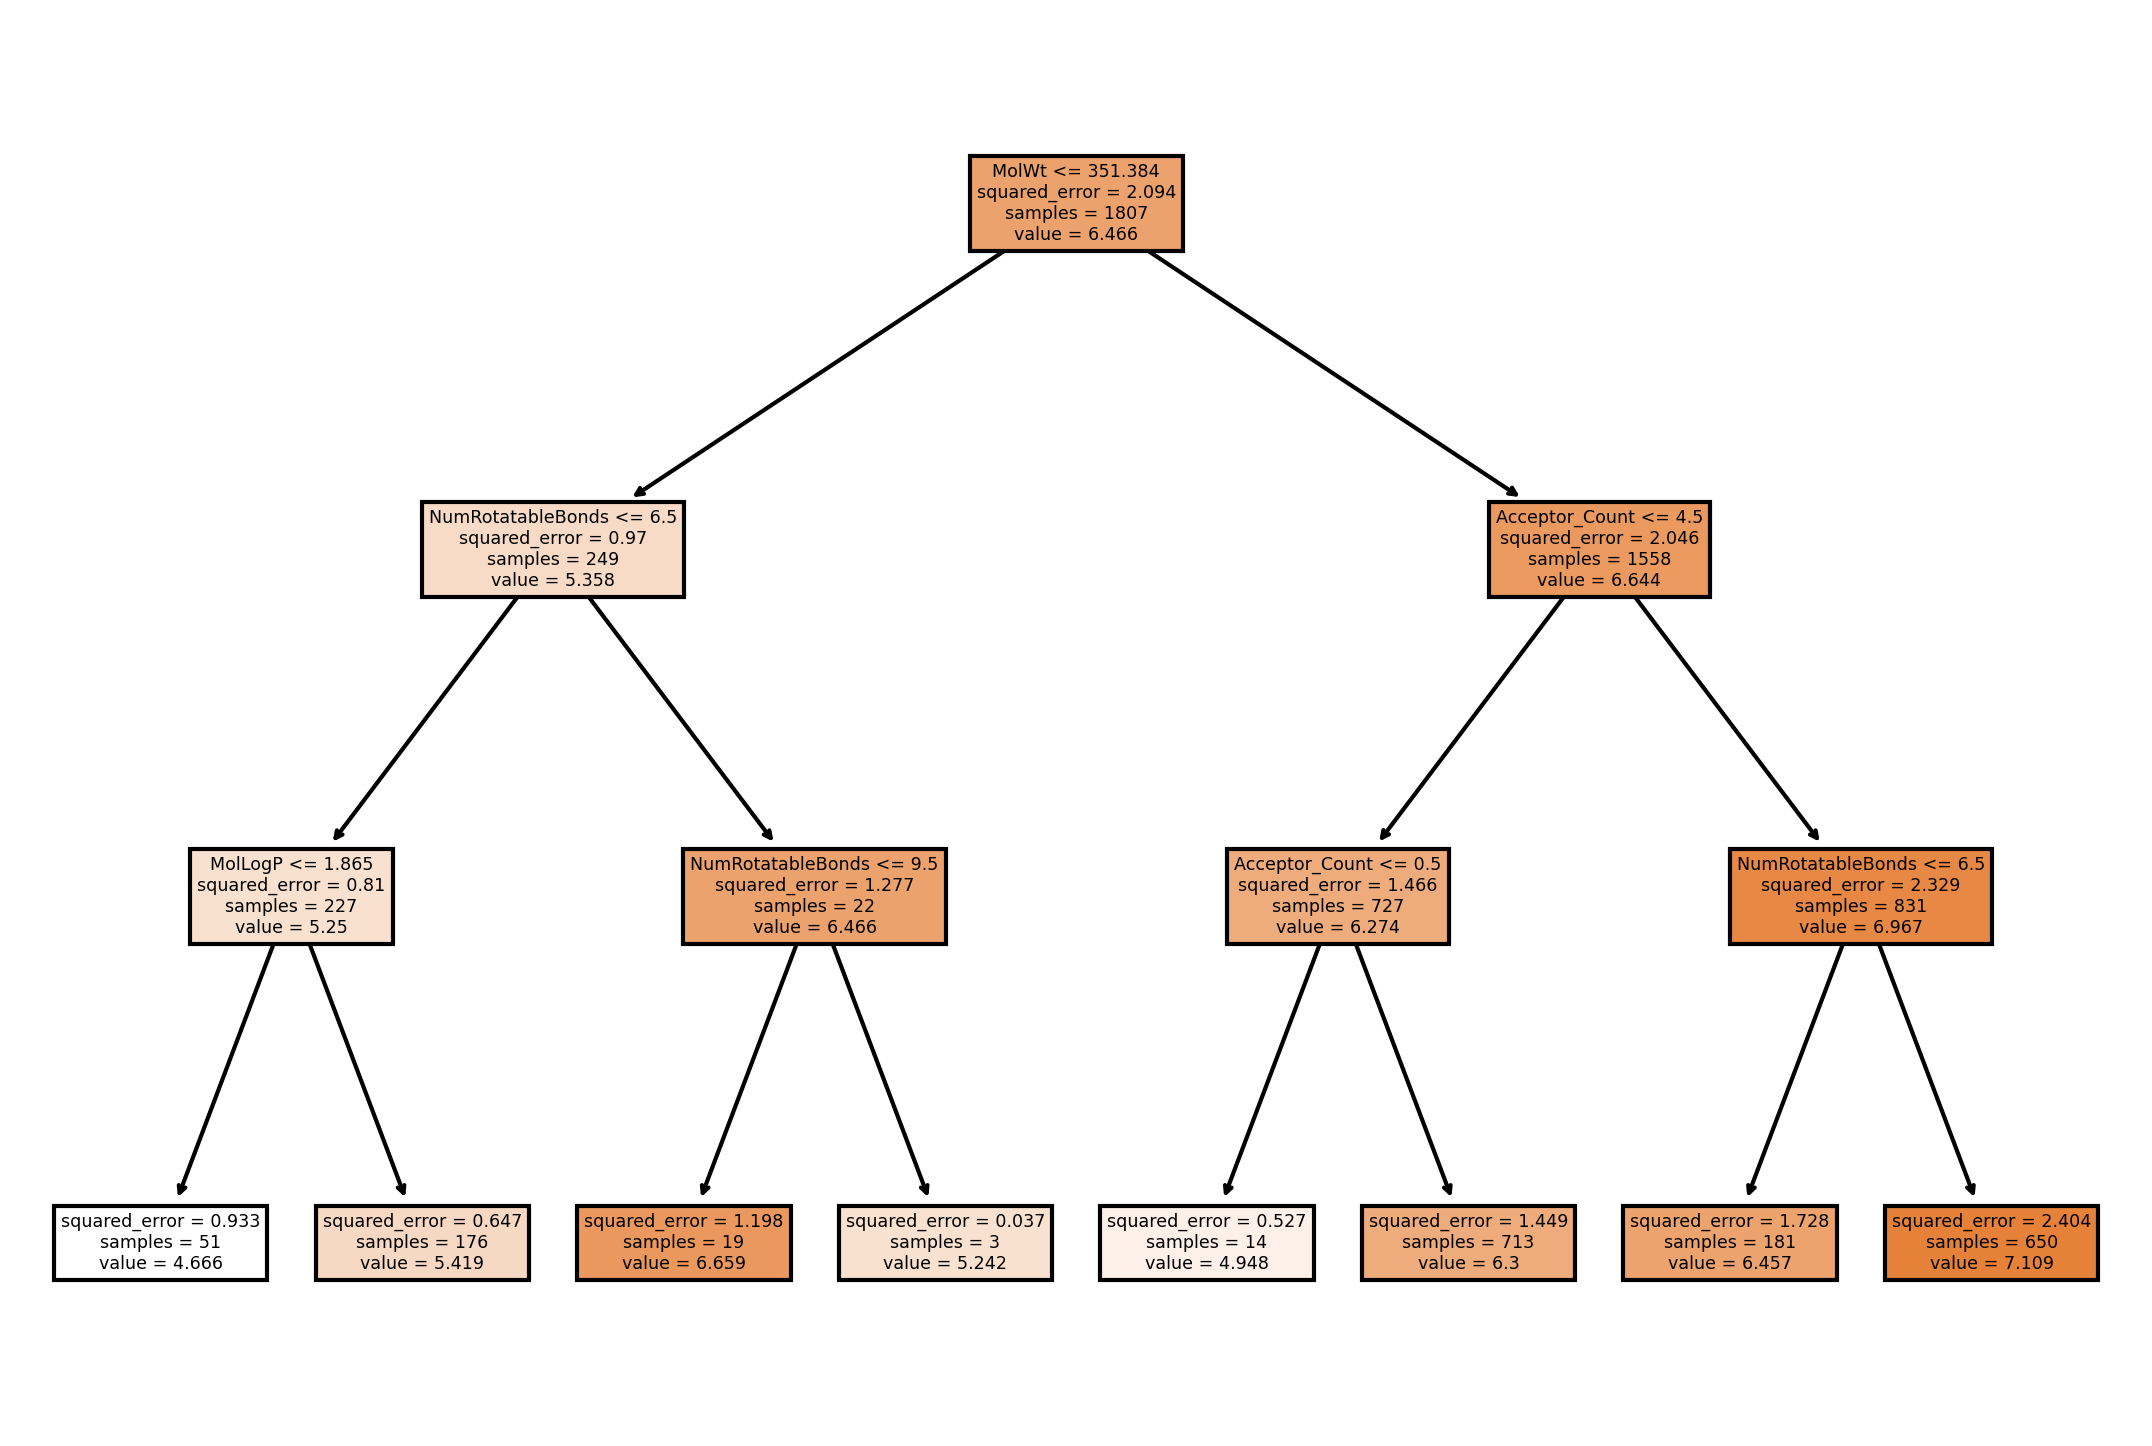

In [142]:
from sklearn import tree

fig, axes = plt.subplots(nrows=1 ,ncols=1, figsize=(9,6), dpi=300) # AVOID RUNNING THIS ON DECISION TREES WITH max_depth < 3 . IT COULD TAKE SOME TIME TO FINISH
tree.plot_tree(regressor, feature_names=X_train.columns.tolist(), filled=True)
plt.show()

Impurity for regression in decision trees is generaly calculated in terms of "variance reduction".

The decision tree algorithm tries the minimise the inpurity of the nodes in the tree.

$ min\frac{1}{N}\sum_{i=1}^{i=N}(yi-\bar{y})^2$

Notice how the splits on the tree above try to "group" similar values (colours).

#### Random Forest

In [143]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()
print(regressor.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [144]:
y_pred_train = cross_val_predict(regressor, X_train, y_train, cv=5)

regressor.fit(X_train, y_train)
y_pred_test = regressor.predict(X_test)

In [145]:
regression_metrics(y_train, y_pred_train, y_test, y_pred_test)

Metric        Training    Test
----------  ----------  ------
RMSE              1.23    1.29
Pearson's         0.53    0.49
Kendall's         0.37    0.36
Spearman's        0.52    0.52


In [146]:
regression_plots(y_train, y_pred_train, y_test, y_pred_test, target)

Which features were more important to the model?

In [147]:
fig = px.bar(x=regressor.feature_names_in_, y=regressor.feature_importances_, title="Feature importance")
fig.update_layout(yaxis_title="Importance score", xaxis_title="Features")
fig.show(renderer="colab")

#### Exploring descriptors in the RDKit library

Try and improve the performance on the predictive models using descriptors from the list below

In [148]:
ds_list = ["BalabanJ","BertzCT","Chi0","Chi0n","Chi0v","Chi1","Chi1n",
           # "Chi1v","Chi2n","Chi2v","Chi3n","Chi3v","Chi4n","Chi4v",
           # "HallKierAlpha","Kappa1","Kappa2","Kappa3","NHOHCount",
           # "NOCount","PEOE_VSA1","PEOE_VSA10","PEOE_VSA11","PEOE_VSA12",
           "PEOE_VSA13","PEOE_VSA14","PEOE_VSA2","PEOE_VSA3","PEOE_VSA4",
           "PEOE_VSA5","PEOE_VSA6","PEOE_VSA7","PEOE_VSA8","PEOE_VSA9",
           # "SMR_VSA1","SMR_VSA10","SMR_VSA2","SMR_VSA3","SMR_VSA4","SMR_VSA5",
           # "SMR_VSA6","SMR_VSA7","SMR_VSA8","SMR_VSA9","SlogP_VSA1","SlogP_VSA10",
           # "SlogP_VSA11","SlogP_VSA12","SlogP_VSA2","SlogP_VSA3","SlogP_VSA4",
           # "SlogP_VSA5","SlogP_VSA6","SlogP_VSA7","SlogP_VSA8","SlogP_VSA9",
           # "VSA_EState1","VSA_EState10","VSA_EState2","VSA_EState3",
           # "VSA_EState4","VSA_EState5","VSA_EState6","VSA_EState7",
           # "VSA_EState8","VSA_EState9","fr_Al_COO","fr_Al_OH","fr_Al_OH_noTert",
           # "fr_ArN","fr_Ar_COO","fr_Ar_N","fr_Ar_NH","fr_Ar_OH","fr_COO","fr_COO2",
           # "fr_C_O","fr_C_O_noCOO","fr_C_S","fr_HOCCN","fr_Imine","fr_NH0",
           # "fr_NH1","fr_NH2","fr_N_O","fr_Ndealkylation1","fr_Ndealkylation2",
           # "fr_Nhpyrrole","fr_SH","fr_aldehyde","fr_alkyl_carbamate",
           # "fr_alkyl_halide","fr_allylic_oxid","fr_amide","fr_amidine","fr_aniline",
           # "fr_aryl_methyl","fr_azide","fr_azo","fr_barbitur","fr_benzene",
           # "fr_benzodiazepine","fr_bicyclic","fr_diazo","fr_dihydropyridine",
           # "fr_epoxide","fr_ester","fr_ether","fr_furan","fr_guanido","fr_halogen",
           # "fr_hdrzine","fr_hdrzone","fr_imidazole","fr_imide","fr_isocyan",
           # "fr_isothiocyan","fr_ketone","fr_ketone_Topliss","fr_lactam","fr_lactone",
           # "fr_methoxy","fr_morpholine","fr_nitrile","fr_nitro","fr_nitro_arom",
           # "fr_nitro_arom_nonortho","fr_nitroso","fr_oxazole","fr_oxime",
           # "fr_para_hydroxylation","fr_phenol","fr_phenol_noOrthoHbond","fr_phos_acid",
           # "fr_phos_ester","fr_piperdine","fr_piperzine","fr_priamide",
           # "fr_prisulfonamd","fr_pyridine","fr_quatN","fr_sulfide","fr_sulfonamd",
           # "fr_sulfone","fr_term_acetylene","fr_tetrazole","fr_thiazole","fr_thiocyan",
           "fr_thiophene","fr_unbrch_alkane","fr_urea"]

In [149]:
from rdkit.Chem import Descriptors

def get_descriptor(row):
    molecule = Chem.MolFromSmiles(row['SMILES'])
    return getattr(Descriptors, ds)(molecule)

for ds in ds_list:
    df_data[ds] = df_data.apply(get_descriptor, axis=1)

In [150]:
df_data.head()

SMILES database  MolLogP  \
0  CN(C)CC[C@H](CSc1ccccc1)Nc1ccc(cc1S(=O)(=O)C(F...   ippidb  8.43850   
1  CSCC[C@H]1NC(=O)CSC[C@H](NC(=O)[C@H](CC(=O)O)N...   timbal -3.84540   
2  CC1CC(C)CN(C1)C2CC(N(C2)S(=O)(=O)c3cccc(c3)C#N...   timbal  4.43398   
3  Cc1cc(Cl)cc([C@@H](CC(=O)O)NC(=O)CNC(=O)c2cc(O...   timbal  0.85362   
4  NC(=N)NCCC[C@@H]1NC(=O)[C@H](Cc2c[nH]cn2)NC(=O...   timbal -4.42303   

   Acceptor_Count  Donor_Count  NumRotatableBonds  RingCount    MolWt  \
0               6            5                 16          7  928.569   
1               9            9                 10          1  620.711   
2               7            4                 10          5  727.671   
3               7            8                  8          3  519.942   
4              10           12                  9          2  626.653   

   Experimental IC50 (log10)   inverse_log  ...  PEOE_VSA3  PEOE_VSA4  \
0                   7.310000  2.041738e+07  ...  26.803551  13.171245   
1                   7.552842  3.571429e+07  ...   4.794537  11.761885   
2                   9.853872  7.142857e+09  ...  13.212334   9.567108   
3                   6.162412  1.453488e+06  ...   0.000000   0.000000   
4                   8.522879  3.333333e+08  ...   9.778516   0.000000   

   PEOE_VSA5  PEOE_VSA6   PEOE_VSA7  PEOE_VSA8  PEOE_VSA9  fr_thiophene  \
0  11.761885  66.198244  118.567824  52.952373  16.276798             0   
1  11.761885   0.000000   31.271088  12.297610  18.718432             0   
2   0.000000  55.248455   60.572742  50.178005  32.136874             0   
3   0.000000  11.600940   36.752657  34.448046  31.656142             0   
4  11.761885   0.000000   12.841643  24.915275  30.739680             0   

   fr_unbrch_alkane  fr_urea  
0                 0        0  
1                 1        0  
2                 0        0  
3                 0        0  
4                 1        0  

[5 rows x 30 columns]

In [151]:
# What is the best TEST_SIZE?
TEST_SIZE = 0.2

columns = ["MolLogP", "Acceptor_Count", "Donor_Count", "NumRotatableBonds",
           "RingCount", "MolWt", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2",
           "PEOE_VSA3", "PEOE_VSA4", "PEOE_VSA5", "PEOE_VSA6", "PEOE_VSA7",
           "PEOE_VSA8", "PEOE_VSA9", "BalabanJ", "BertzCT", "Chi0", 
           "Chi0n", "Chi0v", "Chi1", "Chi1n", "fr_thiophene", 
           "fr_unbrch_alkane", "fr_urea"]

target = "Experimental IC50 (log10)"

X = df_data[columns]
y = df_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

fig = make_subplots(rows=1, cols=2, start_cell="bottom-left")

fig.add_trace(go.Histogram(x=y_train, name='Training set'), row=1, col=1)
fig.add_trace(go.Histogram(x=y_test, name='Test set'), row=1, col=2)
fig.update_xaxes(title=target)
fig.update_yaxes(title="count")
fig.show(renderer="colab")

In [152]:
regressor = RandomForestRegressor()

In [153]:
y_pred_train = cross_val_predict(regressor, X_train, y_train, cv=5)

regressor.fit(X_train, y_train)
y_pred_test = regressor.predict(X_test)

In [154]:
regression_metrics(y_train, y_pred_train, y_test, y_pred_test)

Metric        Training    Test
----------  ----------  ------
RMSE              1.1     1.13
Pearson's         0.65    0.66
Kendall's         0.47    0.48
Spearman's        0.65    0.67


In [155]:
regression_plots(y_train, y_pred_train, y_test, y_pred_test, target)